# Explainable AI

## SHAP (SHapley Additive exPlanations)


---
### What is SHAP?

SHAP (SHapley Additive exPlanations) is a method to explain individual classification predictions. SHAP is based on the game theoretically optimal Shapley Values. For further information on the topic and definitions, please refer to the following resources:



*   https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot
*   https://github.com/slundberg/shap



---

---

Over this worksheet, we will try to find the linkage between characteristics of students and their performance of school. This dataset comes from [UCI](https://archive.ics.uci.edu/ml/datasets/Student+Performance) and it measures the achievements of teenagers in their Portuguese language exams.

We aim to split students into two pools - a "pass" pool (final Portuguese language exam score equal to or above 10) and "fail" group (final language exam score below 10). We will undertake some data cleaning, followed by applying a  popular classification algorithm called LGBM. Finally, we will apply a tree explainer based on SHAP values devised by [Lundberg et al. (2020)](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D).

---


## Example


### Importing libraries & data
As usual, we will start by importing the libraries. Google Colab has many libraries preinstalled, but not all. For this worksheet, we will need to install shap first. `pip` is a python libraries installing tool.

In [2]:
!pip install shap

Now, we can import the extra functionalities from relevant Python libraries.

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from google.colab import drive
from hyperopt import hp, tpe
from hyperopt import space_eval
from hyperopt.fmin import fmin

### Modelling

Having adjusted the data, let us apply the LGBM algorithm, get some initial results and tune its hyperparameters. We put all the hyperparameters into a dictionary, which we can then pass onto our model. We are not aiming here for any brilliant results - simply trying the model out first!


Now, let's assess the model's performance. We can use the simple function below on the test data to check how predictive the classifier is.



In [ ]:
def model_assessment(model, X, y):

    # Get the confusion matrix.
    print("Confusion matrix:")
    disp = plot_confusion_matrix(model, X, y,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()

    # Produce a classification report.
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')
    print("Done!")


**Section(1)**

Use of the Python library XGBoost(Extreme Gradient Boosting)

In [ ]:
import xgboost
import sys

In [ ]:
# Import the data from Google Drive.
portugese_df = pd.read_csv("/content/drive/My Drive/XAI-Worksheets/Portuguese_variable.csv", sep=';')

### Data Processing


- Visually checking what we have in the DataFrame
- Assessing and treating potential missingness
- Creating new labels

In [ ]:
# Get first 5 rows from the top of the table.
portugese_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [ ]:
#df_col_used = portugese_df.columns.tolist()

Builds an array representing the Portugese language scores. If a student has passed (G3 >= 10) or failed (G3 < 10)

In [ ]:
labels = [0 if x  < 10 else 1 for x in portugese_df["G3"]]

With the G3 values stored, the columns G1, G2, G3 are dropped from the dataframe

In [ ]:
portugese_df = portugese_df.drop(columns = ["G1", "G2", "G3"])

To support the XGBoost model, we change the columns with a Pandas data type of "object" to "categorical"

In [ ]:
cats_features = portugese_df.select_dtypes('object').columns.tolist()
for c in cats_features:
    portugese_df[c] = portugese_df[c].astype('category')

portugese_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0


Next we change the category values to be numeric

In [ ]:
cat_columns = portugese_df.select_dtypes(['category']).columns
portugese_df[cat_columns] = portugese_df[cat_columns].apply(lambda x: x.cat.codes)

portugese_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,0,18,1,0,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4
1,0,0,17,1,0,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2
2,0,0,15,1,1,1,1,1,0,2,2,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6
3,0,0,15,1,0,1,4,2,1,3,1,1,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0
4,0,0,16,1,0,1,3,3,2,2,1,0,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0


We can split our data into training dataset representing (80% of the data) and a testing dataset of (20%)

And creates an evaluation set from the training and test datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(portugese_df, labels, test_size=0.2, random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [ ]:
params = {'max_depth': 6,
          'min_child_weight': 0,
          'learning_rate': '0.5',
          'colsample_bytree': '0.75',
          'subsample': 1,
          'reg_lambda': 1,
          'n_estimators': 150}

We apply the XGBClassifier algorithm, fitting the model on the training set

In [ ]:
model = xgboost.XGBClassifier(**params).fit(X_train, y_train, eval_metric=["error"], eval_set=eval_set, verbose=False)

###Model Performance

From assessing our model using the test datasets, the output suggests our model is leaning strongly towards predicting every student to pass the exam. This is indicated by the 0.97 result shown in our confusion matrix.

Confusion matrix:


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


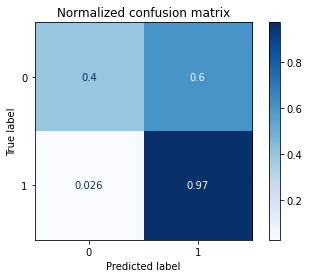

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.93      0.97      0.95       115

    accuracy                           0.91       130
   macro avg       0.80      0.69      0.72       130
weighted avg       0.90      0.91      0.90       130



Done!


In [ ]:
model_assessment(model, X_test, y_test)

We can further evaluate the model by making a prediction using the X_test and comparing this to the y_test dataset. This has returned an encouraging model accuracy of 0.91

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print('Model accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.91


We also considered the performance of the model using the evaluation dataset, and plotting this to get further insight. In this project we looked at the classification errors. The chart shows the scores for our test dataset follow a fairly consistent pattern throughout the process, with only a small gradual decrease.

Within the chart there does not appear to be a good opportunity to stop the learning process early. For this reason we did not apply the early_stopping_rounds parameter.

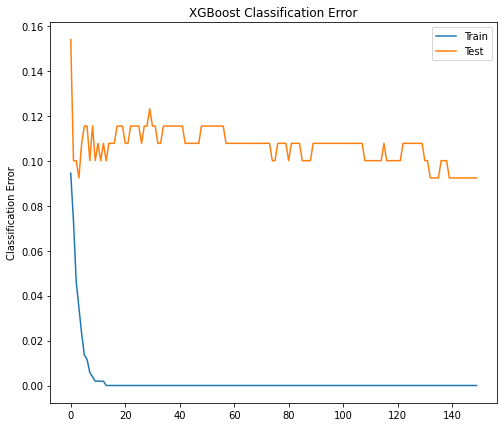

In [ ]:
results = model.evals_result_

plt.rcParams['figure.figsize'] = 8, 7
x_axis = range(len(results['validation_0']['error']))
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

###Calculating the SHAP values

- Used to determine which features are driving the global behaviour of our model


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

#np.set_printoptions(threshold=sys.maxsize)
#shap_values

Summary plot, showing how much each feature contributed to the overall predictions.

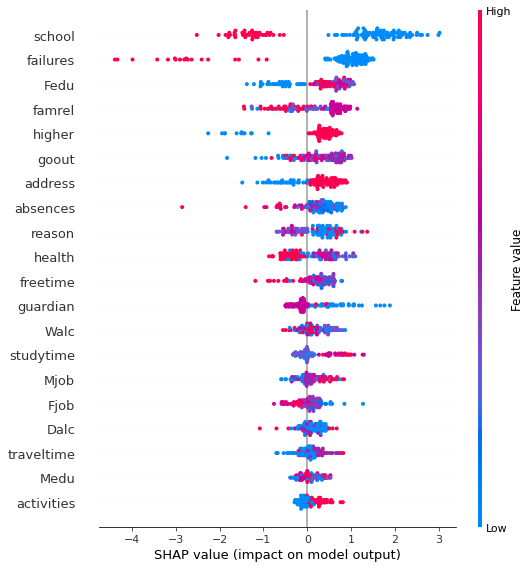

In [ ]:
shap.summary_plot(shap_values, X_test)

**Section(2)**


This bar chart represents the average of the SHAP value magnitudes across the input dataframe

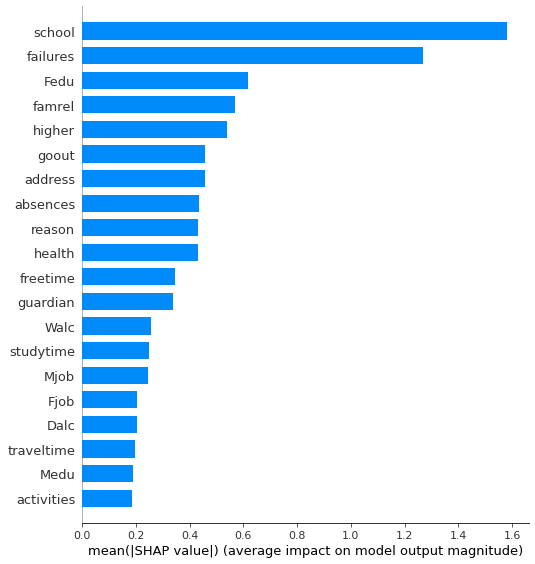

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The 5 most important features in the model:
- school (Student's school)
- failures (Number of past class failures)
- Fedu (Father's level of education)
- famrel (Quality of family relationships)
- higher (Wants to take higher education)

**Section(3)**

The SHAP decision plot shows how the model arrived at it's predictions.

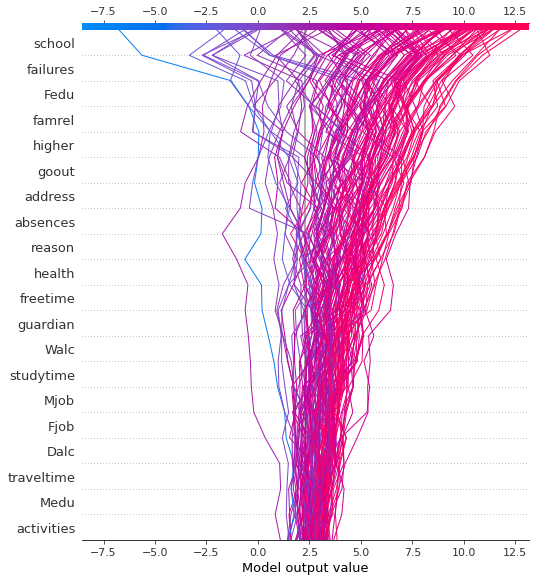

2.3048549

In [ ]:
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values, X_test)
expected_value

Decision plot showing the set of misclassified observations
- The misclassified observations determined by making a prediction on our model using the X_test input. Then checking this predicted outcome with the y_test dataset.

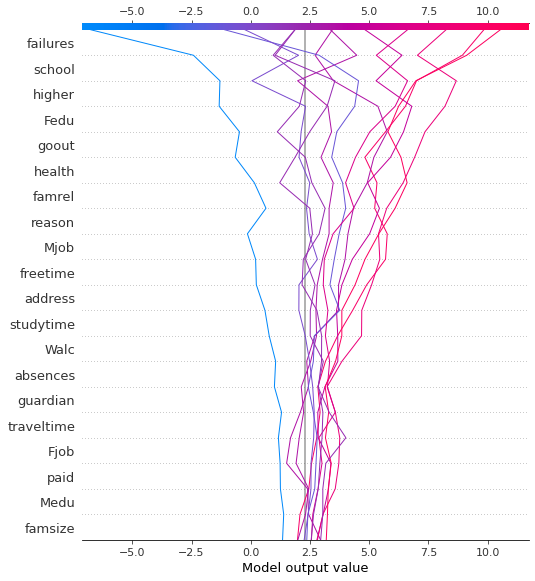

In [ ]:
y_pred = model.predict(X_test)
misclassified = (y_pred != y_test)

shap.decision_plot(expected_value, shap_values[misclassified], X_test[misclassified])

The next four plots represent singular instances, from the set of misclassified observations

In [ ]:
# Index of misclassified observations in the X_test dataset
np.where(misclassified)

(array([ 13,  17,  26,  32,  42,  50,  59,  67,  83,  87, 121, 125]),)

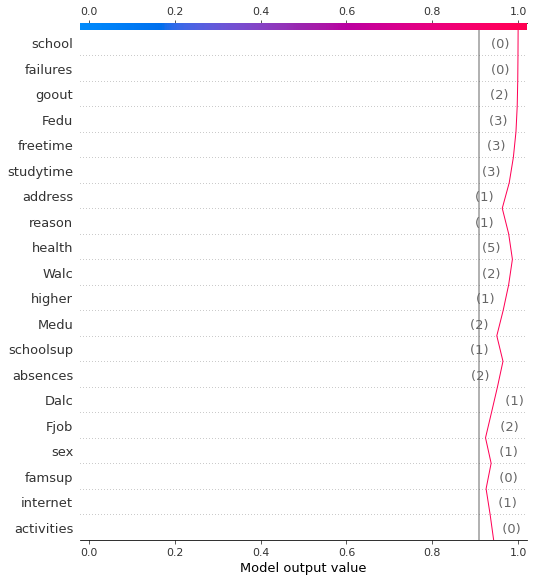

In [ ]:
shap.decision_plot(expected_value, shap_values[13], X_test.iloc[13], link='logit')


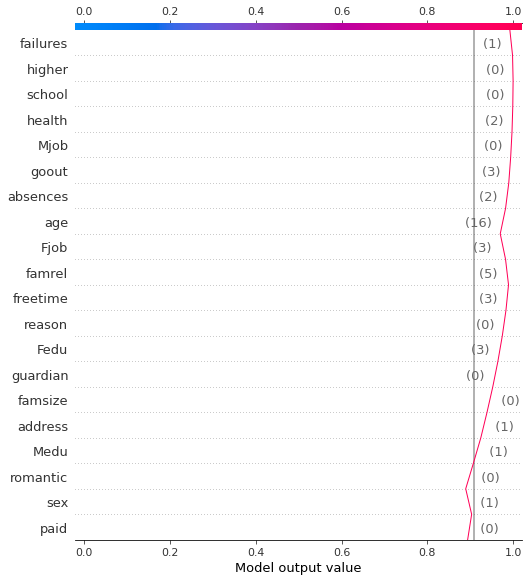

In [ ]:
shap.decision_plot(expected_value, shap_values[26], X_test.iloc[26], link='logit')

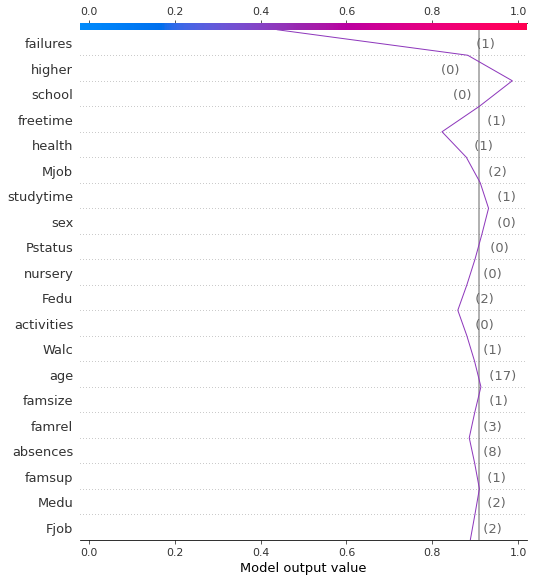

In [ ]:
shap.decision_plot(expected_value, shap_values[59], X_test.iloc[59], link='logit')

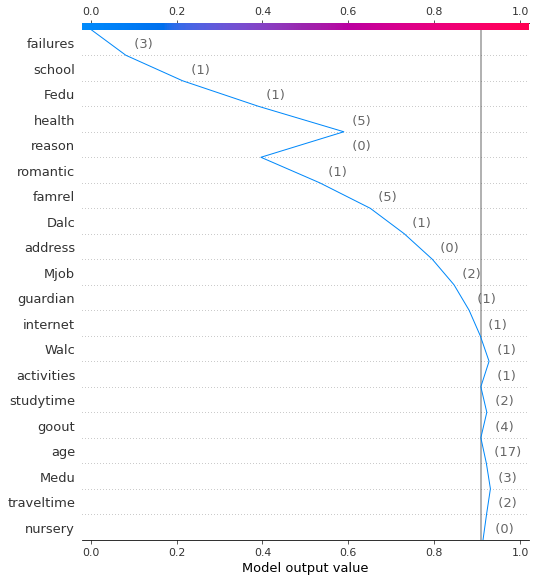

In [ ]:
shap.decision_plot(expected_value, shap_values[67], X_test.iloc[67], link='logit')

A force plot for all observations

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values, X_test)

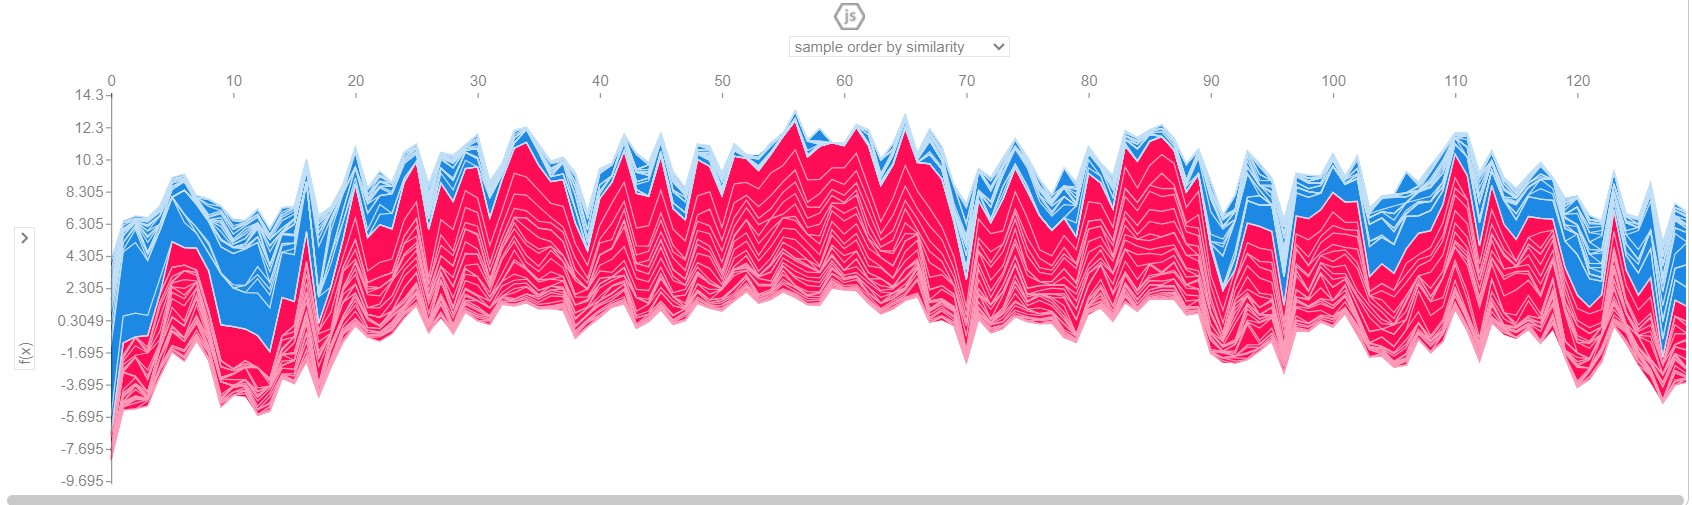

A force plot of the misclassified observations

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[misclassified], X_test[misclassified])

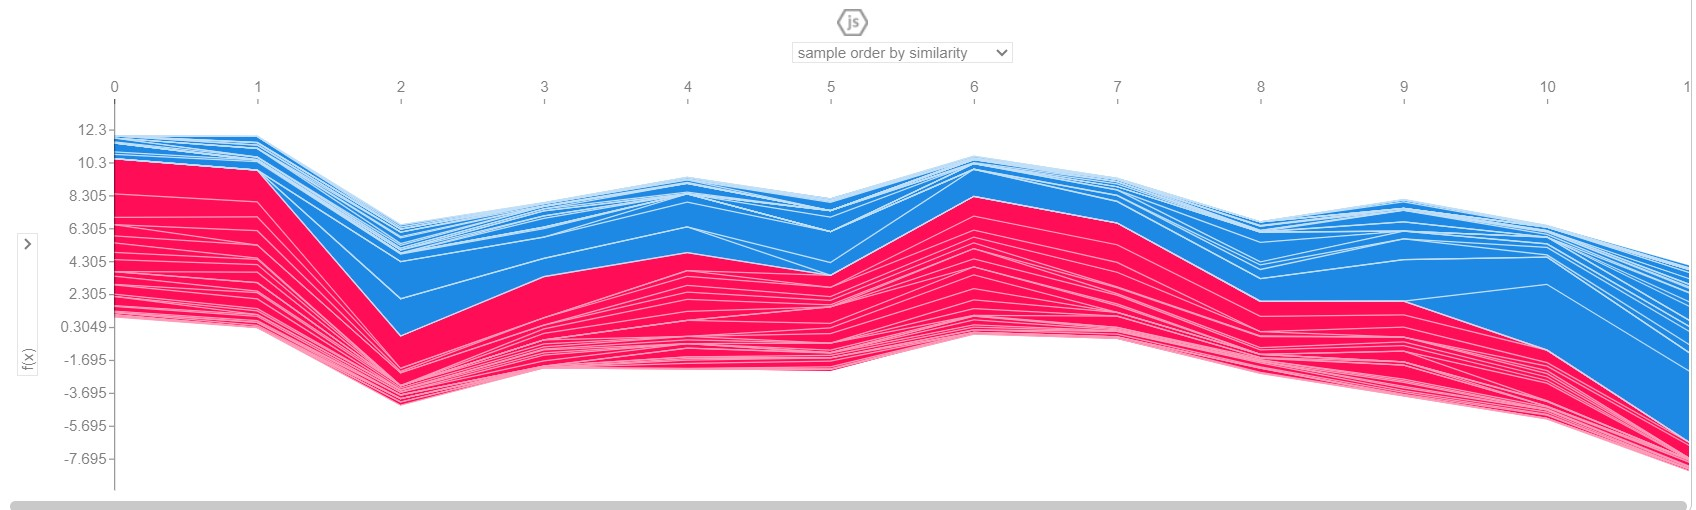

**Section(4)**

Set of SHAP dependence plots, representing the 4 most important features and compared against the feature 'sex'

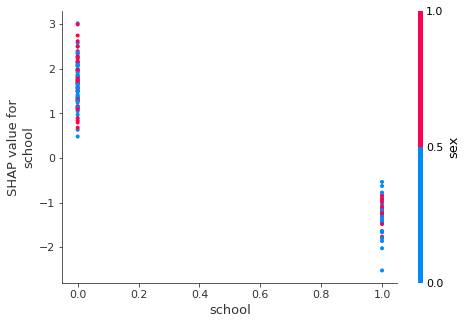

In [ ]:
shap.dependence_plot("school", shap_values, X_test, interaction_index="sex")

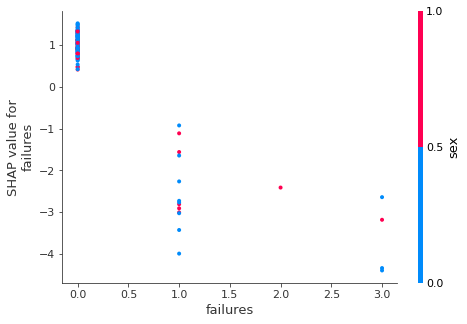

In [ ]:
shap.dependence_plot("failures", shap_values, X_test, interaction_index="sex")

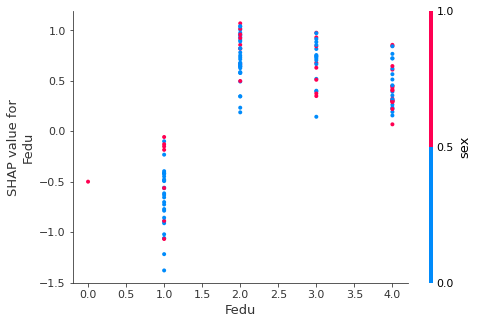

In [ ]:
shap.dependence_plot("Fedu", shap_values, X_test, interaction_index="sex")

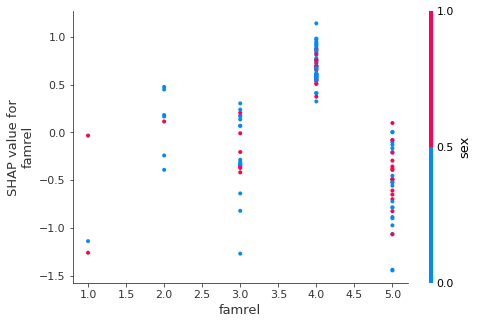

In [ ]:
shap.dependence_plot("famrel", shap_values, X_test, interaction_index="sex")

**Outcomes(1)**

In section three we developed a set of decision plots from the test dataset. These plots illustrate how the model’s prediction changes throughout the decision-making process. We recall the model is predicting: if a student will pass the Portuguese language exam. In the global decision plot, the student’s sex was not directly highlighted as a contributing factor in the decision. Instead, the chart displayed other features ranked by their order of importance.
This might suggest at this level of interpretability, the sex of the student did not meet the threshold to be included in the decision plot.

In Section Four, we developed four dependency plots comparing the features school, failures, fedu, and famrel against the interaction feature sex. For the school feature, the dependency plot shows two distinct groups, which might have been expected considering the dataset contains two mixed sex schools. The failures plot does not show any particular strong correlations.

For the remaining two features fedu and famel, the dependency plots begin to show a real correlation between the features and their interaction with the sex of the students. In particular, fedu, which we recall indicates for a student their (Father's level of education). This chart presents three groups of positive values for males, when their father has attained higher levels of education.

For the famrel (Quality of family relationships), higher relationship values are more spread between the two sexes. Though, female students tend to exhibit the highest family relationship scores.

Although this discussion has only considered a small set of charts, the results suggest an interaction effect between the student's sex, and other features. This effect influences the model’s decisions but is only apparent at the local interpretability level. Additional research would be required to outline this further.

**Outcomes(2)**

In machine learning, the term Model Validation refers to a set of processes and activities used to quantify a models prediction. In most situations, ensuring the model is predictive and accurate for its intended use.

In this discussion we focus on SHAP (SHapley Additive exPlanations), which is a technique used to explain the output of any model. The SHAP values break down a prediction, to show the impact of each feature.

SHAP values, can be graphed at a global and local level. At a global level they help to interpret and understand the overall model prediction. Graphs, such-as summary plots which show how observations linked to each feature, can shift the prediction in a positive or negative direction. These features are positioned top to bottom in order of importance. In model validation this provides an opportunity to understand the importance of certain features, and ensure they are consistent with our expectation.

At a local level, the focus moves to interpreting each observation and how they affect the model predictions. Graphs such-as the individual force plots, which show a separate set of SHAP values for each observation. For our developed model, validation provides a high level of transparency by breaking down the contributions to each prediction.

There is also a third set of SHAP graphs, which provide both global and local interpretability. The dependence plot graph shows the marginal effect one or two features can have on a models prediction. Or at a local level, if two features have an interaction effect. The decision plot can be used to show how the prediction changes during the decision process. Together these SHAP graphs provide another set of tools to support the process of model validation.



**Final Notes(3)**

Using SHAP as an XAI technique over this project, has revealed that model predictions can indeed be broken down to show the impact of each feature. The choice of model is key to having a successful set of SHAP outputs. Out of the many available models this project utilised the XGB model, which stands for ‘Extreme Gradient Boosting’. Gradient boosting, is a technique useful for both regression and classification problems. The XGB model works by sequentially making predictions then adding these to the group, at each stage the process tries to correct for any errors and to produce an improved prediction model. The predictions are often stored in a tree, which we can imagine as a set of branches spreading out. This structure makes the model fast and scalable, ideal for producing sets of SHAP values.